# <font color='blue'>**LABORATORIO 1. Visión computacional Tradicional y ANN´s aplicadas a problemas de clasificación de imágenes**

<font color='red'>Integrantes (Máximo 3 personas):

<font color='red'>Nelson Andres Delgado Machado

<font color='red'>2236571

<font color='red'>Jhon Edinson Caicedo Loaiza

<font color='red'>2236467

Las CNN's en general se consideran buenos clasificadores, sin embargo estas soluciones tienden a ser consideradas cajas negras. Una manera de comenzar a entender los procesos que se suceden al interior de sistemas de clasificación es usar técnicas tradicionales.

La base de este tipo de clasificadores es el sistema que se use para extraer características. En clase, hemos realizado un pequeño modelo haciendo uso de herramientas básicas como : SIFT (Detector/Descriptor) , VBoW y MLP.

Siga las instrucciones (<font color='red'>resaltadas en rojo </font>), las cuales además de guiarlo, generarán en suma el puntaje final obtenido para este laboratorio.

In [ ]:
#Para dar un orden al trabajo realizado, coloque aqui todas las librerias que van a ser usadas.
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from skimage.feature import hog
from skimage import exposure


In [ ]:
# Vamos a usar el Sign Language Digits Dataset
#By Turkey Ankara Ayrancı Anadolu High School Students.

!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git


Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [ ]:
#Esta parte esta hecha para ustedes.
#Se les pide que intenten seguir el código y entender
#lo que se hace y el porque se hace. Que tan importante es usar pathlib en este caso?

import os
import pathlib
sld_dir = pathlib.Path('Sign-Language-Digits-Dataset/Dataset/')
print(len(list(sld_dir.glob('*/*.JPG'))))

imagenes={}

for ruta in sld_dir.glob('*'):
  categoria=[]
  for filename in ruta.glob('*.JPG'):
    img = cv2.imread(str(filename))
    if img is not None:
        categoria.append(img)
  imagenes[ruta.name] =  categoria

2062


* **Que tan importante es usar pathlib en este caso?**

Usar pathlib en este caso es importante ya que permite disminuir las lineas de codigo, al no tener que estar indicando las rutas; es decir permite escribir código más limpio y legible al proporcionar una sintaxis más intuitiva para trabajar con rutas y archivos.

In [ ]:
print(imagenes.keys())

dict_keys(['0', '3', '5', '9', '8', '6', '7', '1', '2', '4'])


<font color='red'>Punto 1 (0.5). Preprocesamiento</font>.

El pre-procesamiento de imagenes es una tarea fundamental cuando se desea que la IA trabaje correctamente.

Lea el documento que aparece en este [link](https://medium.com/spidernitt/image-preprocessing-why-is-it-necessary-8895b8b08c1d), el cual aborda este tema de una manera clara y concisa.

(a) Realice el código necesario para cumplir con la labor de pre-procesamiento del dataset dado, indicando cual o cuales técnicas utilizó y la razón que tuvo para usarlas.

(b) Realice un código que le permita mostrar nueve imagenes aleatorias seleccionadas del dataset, mostrando el antes y el despues del pre-procesamiento.


**a.** Para el pre-procesamiento del dataset se uso las tecnicas del resize y el gray scale, esto con el fin de que al redimensionar se tenga el mismo formato y dimension, asi mismo se usa la tecnica del grayscale porque convertir las imágenes a escala de grises reduce la complejidad del conjunto de datos al tener solo un canal. Esto puede acelerar el entrenamiento y reducir la cantidad de recursos necesarios, mientras que todavía se conserva la información esencial para muchas tareas de clasificación

In [ ]:
#Pegue y ejecute aquí el código para la tarea de preprocesamiento.

#resize and gray scale
def prepro(imagenes):
  width = 64
  height = 64
  dim = (width, height)

  img_resize = {}

  for categoria, imgs in imagenes.items():
      nuevas_imagenes = []  # Lista para almacenar las nuevas imágenes copiadas
      for imagen in imgs:
        img_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(img_gris, dim, interpolation = cv2.INTER_AREA)
        nuevas_imagenes.append(resized)  # Copia la imagen a la nueva lista
      img_resize[categoria] = nuevas_imagenes

  return img_resize

In [ ]:
img_resize = {}
img_resize = prepro(imagenes)

In [ ]:
#Pegue y ejecute  aquí el código para crear  el visualizador.
def plotear_imagenes_aleatorias(imagenes_diccionario,imagenes_resize, num_imagenes=9):
    categorias = list(imagenes_diccionario.keys())
    plt.figure(figsize=(12, 4))

    for i in range(num_imagenes):
        categoria = random.choice(categorias)
        imagenes_categoria = imagenes_diccionario[categoria]
        imagenes_categoria_prepro = imagenes_resize[categoria]
        a = len(imagenes_diccionario[categoria])
        n = random.randint(0,a)
        imagen = imagenes_categoria[n]
        imagen_prepro = imagenes_categoria_prepro[n]
        plt.subplot(2, 9, i+1)
        plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        plt.title(categoria)
        plt.axis('off')
        plt.subplot(2, 9, i+10)
        plt.imshow(imagen_prepro, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

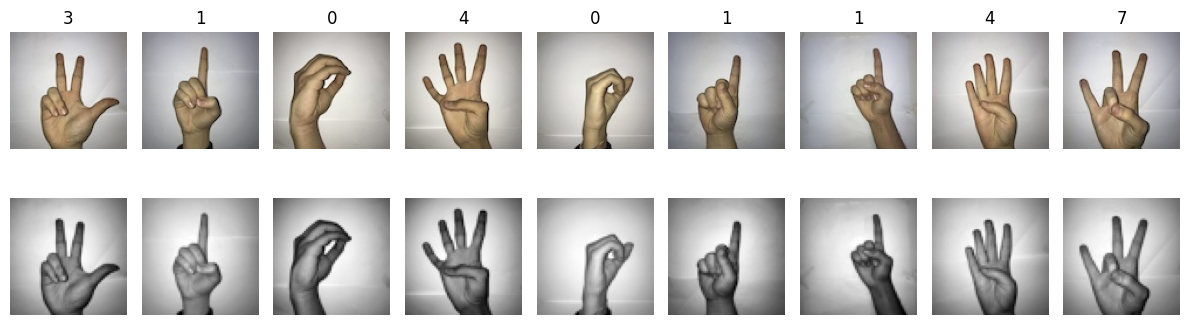

In [ ]:
plotear_imagenes_aleatorias(imagenes, img_resize)

<font color='red'>Punto 2 (2.0). Cree un clasificador tradicional para el dataset dado, usando SIFT como Detector/Descriptor.

(1.0) Utilice los conocimientos adquiridos en clase acerca de visión computacional tradicional: detectores/descriptores, BoVW y ANN´s para que cree, entrene y valide un CLASIFICADOR TRADICIONAL.

(0.5) ¿Cómo seleccionó el numero de palabras en su diccionario? (Lea acerca de la técnica KNN y el ELBOW METHOD, para crear una función que le permita obtener el K óptimo)

(0.5) ¿Como seleccionó o creó la estrucutra de su modelo MLP? (De una explicación clara y concisa. Tenga en cuenta dentro de su explicación dar respuesta a la selección de: numero de capas, numero de neuronas por capa, función de activación, optimizador)



**¿Cómo seleccionó el numero de palabras en su diccionario?**

El numero de palabras del diccionario se escogio a partir del metodo ELBOW, teniendo en cuenta que el K optimo es el punto donde la distancia de los clusters no disminuyen en el grafico.

**¿Como seleccionó o creó la estrucutra de su modelo MLP?**

La estructura del modelo diseñado se creo con los siguientes parametros:
Para el numero de capas se opto por tres ya que con esta se permite una representacion profunda para capturas los patrones y los datos obtenidos.

Para el número de Neuronas por Capa; Se eligieron 700 neuronas para la primera capa, 500 para la segunda y 10 para la tercera. Estas cantidades se ajustan al problema de clasificacion ya que al tener bastantes neuronas ayuda a extraer caracterisitcas mas complejas, mientras haya un menor numero de neuronas en la capa de sali ya que esta ayuda a coincidir en el numero de clases en la clasificacion.

Para la funcion de activacion se utilizó ReLU en todas las capas ocultas. esto debido a que ayuda a tener una mejor eficiencia en la solucion de problemas y su capacidad para modelar los entrenamientos de manera efectiva.

Para el optimizador se eligió el Adam, esto debido a la capacidad de ajustar las tasas de aprendizaje automaticamente.




In [ ]:
#dividimos el diccionario en entrenamiento y testeo
categorias = list(img_resize.keys())
datos_entrenamiento = {}
datos_prueba = {}

for categoria in categorias:
    imagenes_categoria = img_resize[categoria]
    imagenes_entrenamiento, imagenes_prueba = train_test_split(imagenes_categoria, test_size=0.3, random_state=42)
    datos_entrenamiento[categoria] = imagenes_entrenamiento
    datos_prueba[categoria] = imagenes_prueba


In [ ]:
print(len(datos_entrenamiento['0']))
print(len(datos_prueba['0']))

143
62


In [ ]:
def features(imagenes):
  sift = cv2.SIFT_create()
  feat_all = []
  featXcat = {}

  for key, imgs in imagenes.items():
    featXimg = []
    for img in imgs:
      kp, desc = sift.detectAndCompute(img, None)
      feat_all.extend(desc)
      featXimg.append(desc)

    featXcat[key] = featXimg
  return [feat_all, featXcat]

In [ ]:
feat_train = features(img_resize)

In [ ]:
#Pegue y ejecute aquí su código para definir el K óptimo
feat_all = feat_train[0]
distortions = []
K_range = range(1, 100)  # Probamos con k desde 1 hasta 20
for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feat_all)
    distortions.append(kmeans.inertia_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

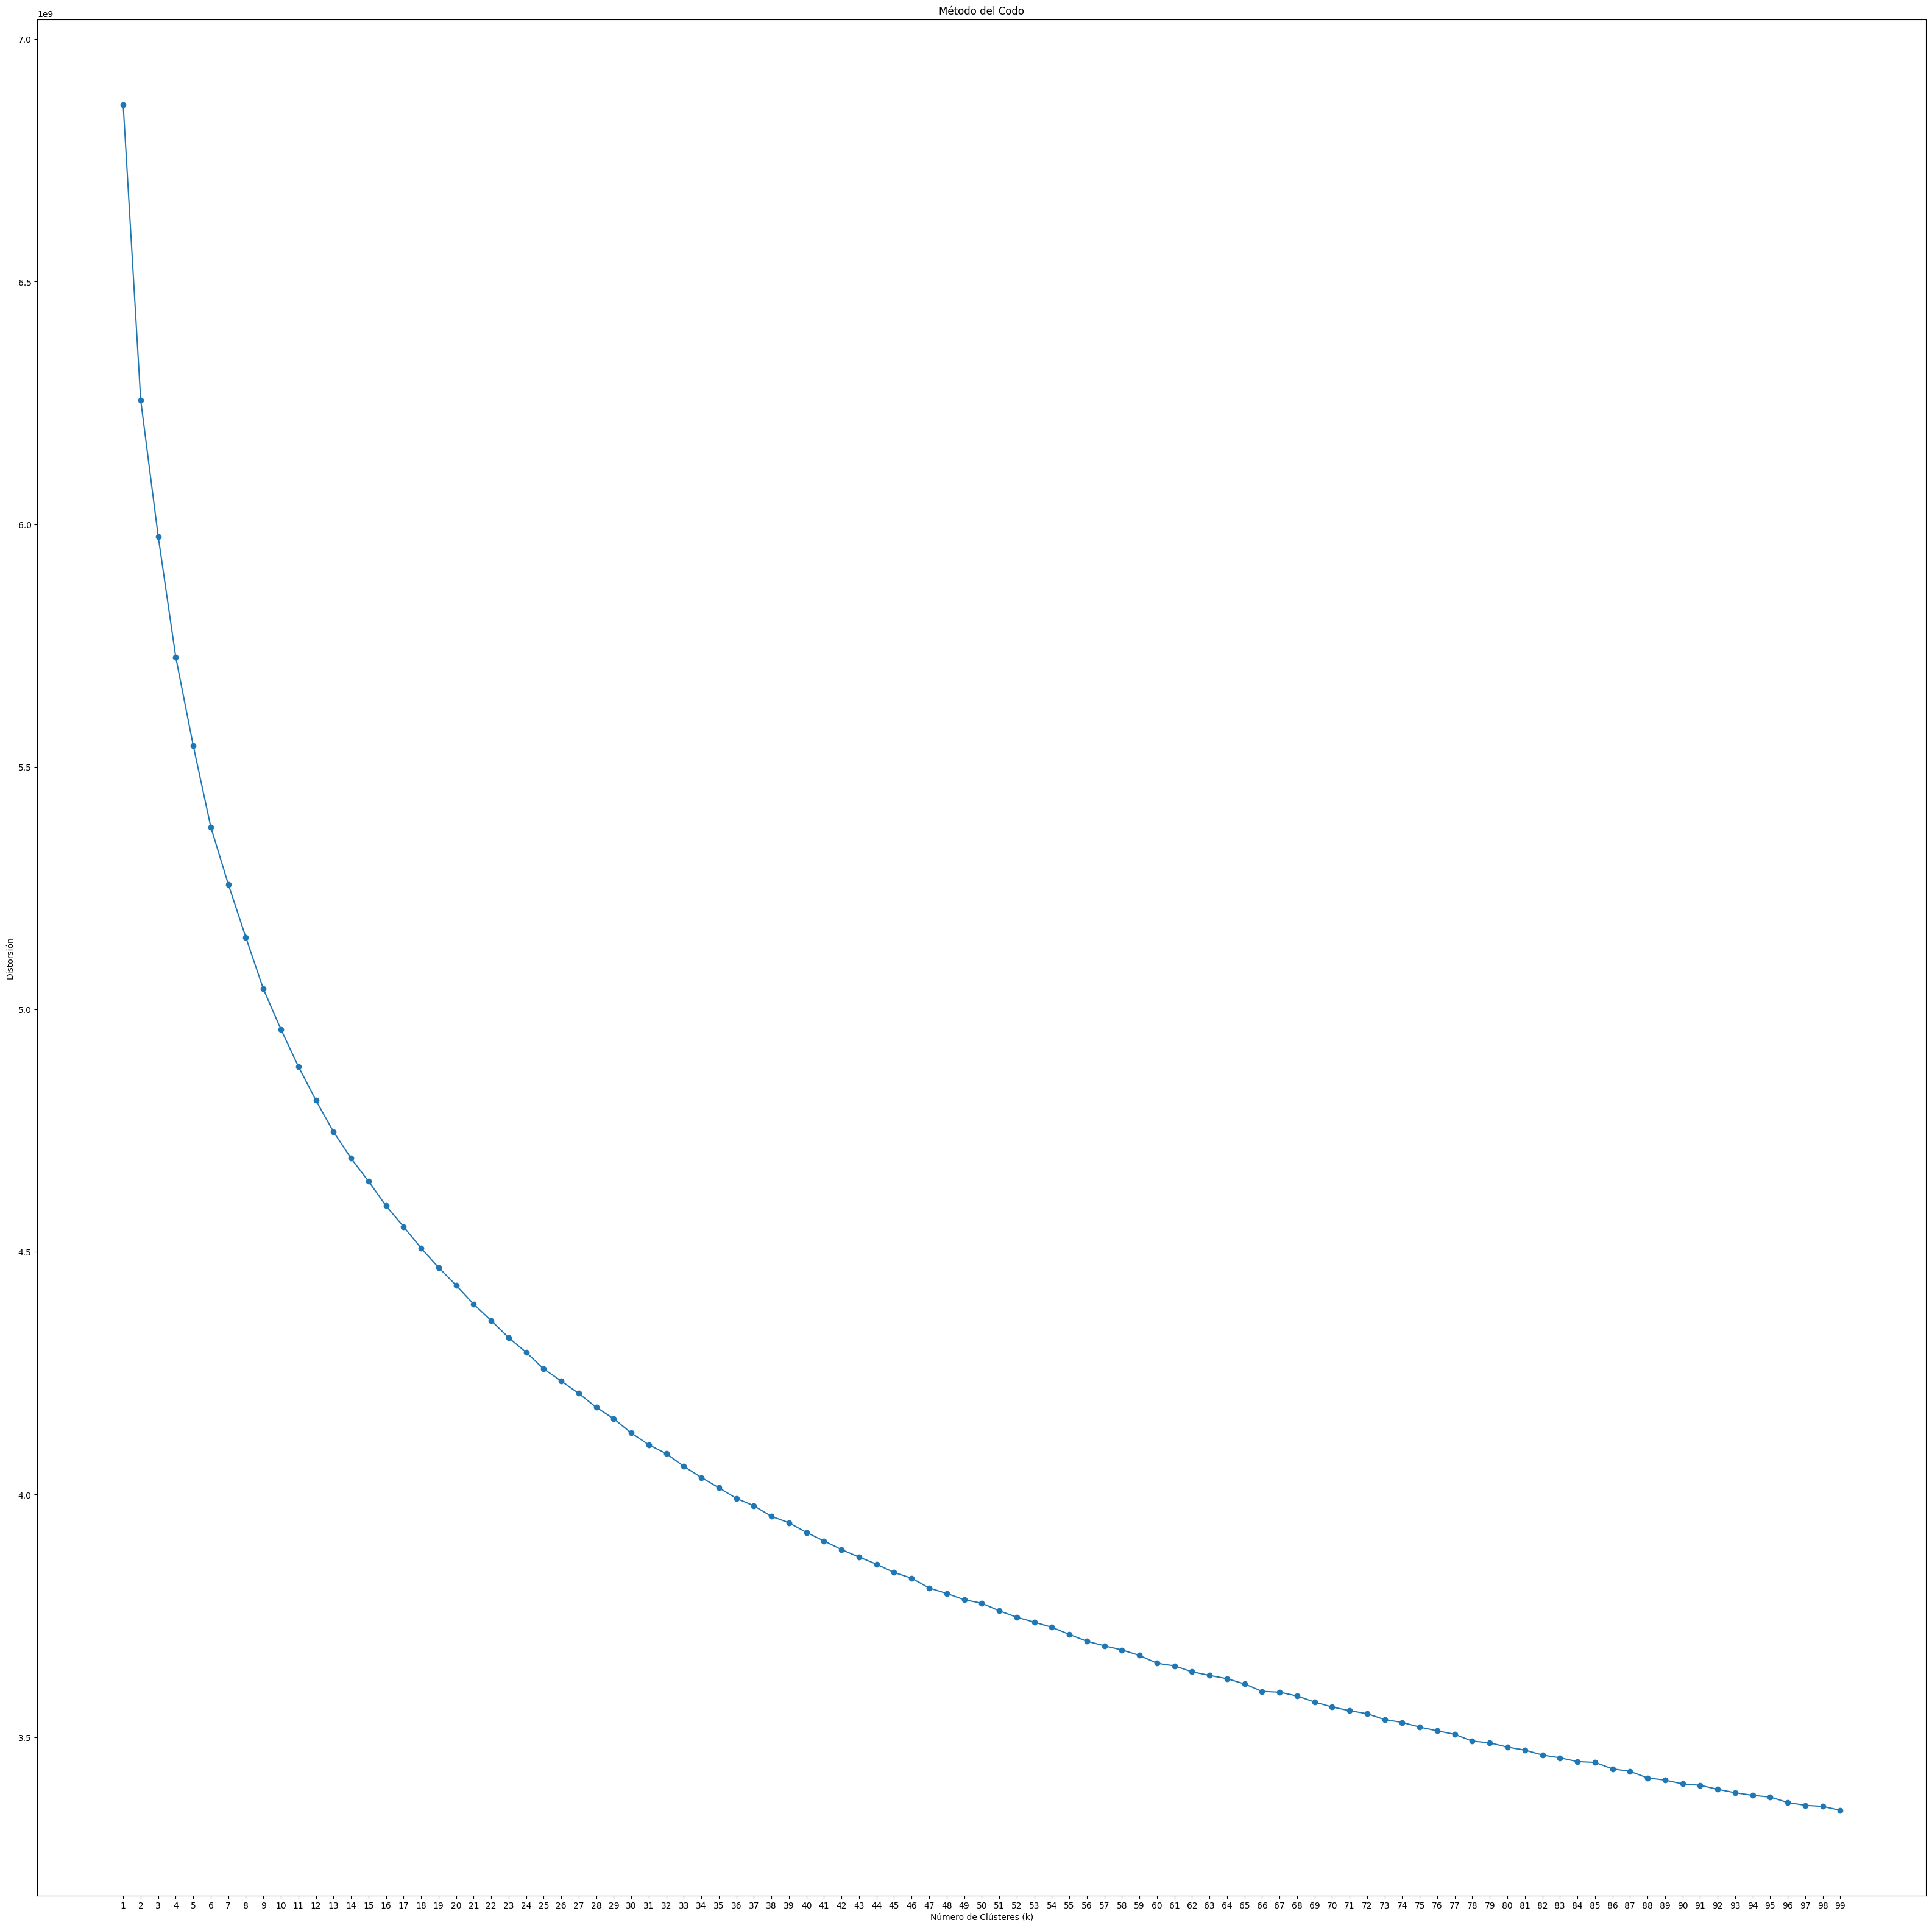

In [ ]:
plt.figure(figsize=(40, 40))
plt.plot(K_range, distortions, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Distorsión')
plt.xticks(K_range)
plt.show()

In [ ]:
#se crea el diccionario
def clustering(k,lista):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(lista)
  diccionario = kmeans.cluster_centers_
  return diccionario

In [ ]:
def find_idx(feat, center):
  count = 0
  ind = 0
  for i in range(len(center)):
    if (i == 0):
      count = distance.euclidean(feat, center[i])
    else:
      dist = distance.euclidean(feat, center[i])
      if (dist < count ):
        ind = i
        count = dist
  return ind

In [ ]:
def img_histos(bovw_feat, centers):
  dict_feat = {}
  for key, value in bovw_feat.items():
    imagens = []
    for img in value:
      histo = np.zeros(len(centers))
      for each_feat in img:
        idx = find_idx(each_feat, centers)
        histo[idx]+=1
      imagens.append(histo)
    dict_feat[key] = imagens
  return dict_feat

In [ ]:
#Una forma de encontrar el K optimo es realizando la curva del codo. ELBOW
k = 25
diccionario_vis = clustering(k, feat_train[0])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
bovw_train = img_histos(feat_train[1], diccionario_vis)

In [ ]:
def preparar_datos(diccio):
  y = []
  x = []
  for key, values in diccio.items():
    for histo in values:
      x.append(histo)
      y.append(key)
  return np.array(x), np.array(y)

In [ ]:
x_train, y_train = preparar_datos(bovw_train)

In [ ]:
feat_test = features(datos_prueba)[1]
bovw_test = img_histos(feat_test, diccionario_vis)
x_test, y_test = preparar_datos(bovw_test)

std = StandardScaler().fit(x_train)
x_train = std.transform(x_train)
x_test = std.transform(x_test)

In [ ]:
#Pegue y ejecute aquí su código del entrenamiento, validación de su clasificador tradicional
mlp = MLPClassifier(hidden_layer_sizes=(700,500,10), activation='relu', solver='adam', max_iter=40)
mlp.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(700, 500, 10), max_iter=40)

In [ ]:
p = mlp.predict(x_test)

In [ ]:
#Pegue y ejecute aquí su código de la metricas usadas.

In [ ]:
M = confusion_matrix(y_test, p)

In [ ]:
cm = confusion_matrix(y_test, p, labels= mlp.classes_)
print(cm)

[[62  0  0  0  0  0  0  0  0  0]
 [ 2 60  0  0  0  0  0  0  0  0]
 [ 0  1 61  0  0  0  0  0  0  0]
 [ 0  0  0 62  0  0  0  0  0  0]
 [ 0  0  0  0 62  0  0  1  0  0]
 [ 0  0  0  0  0 63  0  0  0  0]
 [ 0  0  0  0  0  0 63  0  0  0]
 [ 0  0  0  0  0  1  0 61  0  0]
 [ 0  2  0  0  0  0  0  0 61  0]
 [ 0  1  0  0  0  0  0  0  0 61]]


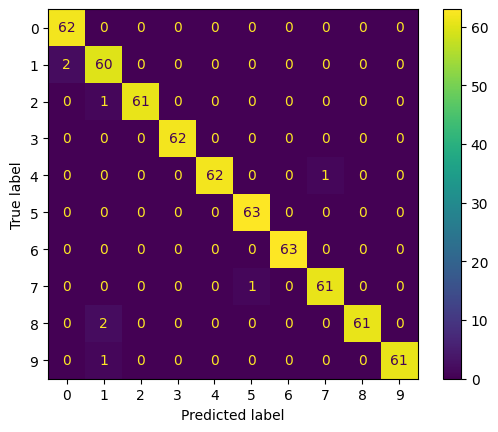

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.94      0.97      0.95        62
           2       1.00      0.98      0.99        62
           3       1.00      1.00      1.00        62
           4       1.00      0.98      0.99        63
           5       0.98      1.00      0.99        63
           6       1.00      1.00      1.00        63
           7       0.98      0.98      0.98        62
           8       1.00      0.97      0.98        63
           9       1.00      0.98      0.99        62

    accuracy                           0.99       624
   macro avg       0.99      0.99      0.99       624
weighted avg       0.99      0.99      0.99       624



<font color='red'>Punto 3 (1.5). Cree un clasificador tradicional para el dataset dado, usando HOG.</font>

(1.0) Lea acerca del HOG (Histogram of Gradients) y uselo como entrada a su CLASIFICADOR TRADICIONAL, sustituyendo de esta manera a SIFT.
<font color='red'> [Nota: Solo puede cambiar el vector de entrada a su modelo.]

(0.25) De una explicación corta acerca (No más de 10 líneas) de como HOG modifica el código implementado.

(0.25) Muestre una tabla comparando las metricas obtenidas. (SIFT Vs HOG). Realice un análisis de los resultados obtenidos.

**De una explicación corta acerca (No más de 10 líneas) de como HOG modifica el código implementado.**

El método Histogram of Oriented Gradients (HOG) transforma imágenes al enfocarse en los cambios de intensidad en pequeñas regiones. En lugar de mirar la imagen completa, HOG calcula la dirección de los cambios de intensidad en pequeñas áreas llamadas celdas. Luego, crea histogramas de estas direcciones en cada celda. Al combinar estos histogramas de todas las celdas, obtiene un vector que describe cómo se distribuyen los cambios de intensidad en la imagen. Este vector captura detalles importantes como bordes y texturas, resultando en una representación compacta y útil para tareas como detección de objetos.

In [ ]:
#Pegue y ejecute aquí su código del entrenamiento, validación de su clasificador tradicional
sld_dir = pathlib.Path('Sign-Language-Digits-Dataset/Dataset/')
print(len(list(sld_dir.glob('*/*.JPG'))))

imagenes1={}

for ruta in sld_dir.glob('*'):
  categoria1=[]
  for filename in ruta.glob('*.JPG'):
    img1 = cv2.imread(str(filename))
    if img1 is not None:
        categoria1.append(img1)
  imagenes1[ruta.name] =  categoria1

2062


In [ ]:
def prepro1(imagenes):
  width = 64
  height = 128
  dim = (width, height)

  img_resize1 = {}

  for categoria, imgs in imagenes.items():
      nuevas_imagenes = []  # Lista para almacenar las nuevas imágenes copiadas
      for imagen in imgs:
        img_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(img_gris, dim, interpolation = cv2.INTER_AREA)
        nuevas_imagenes.append(resized)  # Copia la imagen a la nueva lista
      img_resize1[categoria] = nuevas_imagenes

  return img_resize1

In [ ]:
img_resize1 = {}
img_resize1 = prepro1(imagenes)

In [ ]:
x1=[]
y1=[]
for categoria, imgs in img_resize1.items():
  for imagen in imgs:
    x1.append(imagen)
    y1.append(categoria)

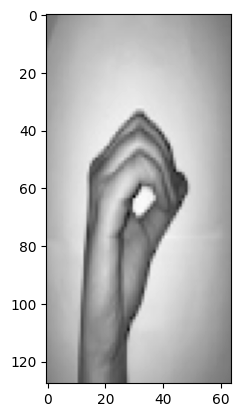

In [ ]:
plt.imshow(x1[6], cmap=plt.cm.gray)

In [ ]:
xhog=[]
for i in range(len(x1)):
  a =x1[i]
  fd, hog_image = hog(a, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
  xhog.append(hog_image)


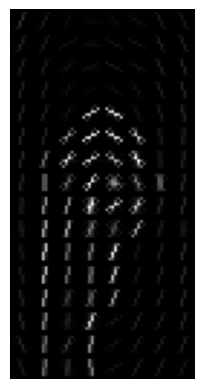

In [ ]:
plt.axis("off")
plt.imshow(xhog[6], cmap="gray")
plt.show()

In [ ]:
xhog= np.array(xhog)

In [ ]:
y1=np.array(y1)

In [ ]:
xtrain1, xtest1, ytrain_1, ytest_1 = train_test_split(xhog, y1, test_size=0.3, random_state=42)

In [ ]:
xtrain1_flat = xtrain1.reshape(xtrain1.shape[0], -1)

In [ ]:
xtest1_flat = xtest1.reshape(xtest1.shape[0], -1)

In [ ]:
xtrain1_flat = (xtrain1_flat-xtrain1_flat.min())/(xtrain1_flat.max()-xtrain1_flat.min())
xtest1_flat = (xtest1_flat-xtest1_flat.min())/(xtest1_flat.max()-xtest1_flat.min())

In [ ]:
mlphog = MLPClassifier(hidden_layer_sizes=(700,500,10), activation='relu', solver='adam', max_iter=40)
mlphog.fit(xtrain1_flat,ytrain_1)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(700, 500, 10), max_iter=40)

In [ ]:
predictions = mlphog.predict(xtest1_flat)

In [ ]:
Mhog = confusion_matrix(ytest_1, predictions)

In [ ]:
#Pegue y ejecute aquí su código de la metricas usadas. Acompañelo de la tabla comparativa (SIFT vs HOG)

In [ ]:
cm1 = confusion_matrix(ytest_1, predictions, labels= mlphog.classes_)
print(cm1)

[[50  1  0  0  0  0  3  0  0  1]
 [ 2 55  3  0  0  0  1  1  0  0]
 [ 0  0 58  0  0  0  2  0  0  0]
 [ 0  1  2 64  1  1  0  1  0  0]
 [ 0  0  0  0 57  0  2  1  0  1]
 [ 0  0  0  0  0 75  0  0  0  2]
 [ 0  0  4  0  1  0 49  0  1  0]
 [ 0  0  1  0  3  0  6 53  2  0]
 [ 0  0  0  0  2  0  1  2 44  3]
 [ 0  1  0  0  2  1  0  0  4 54]]


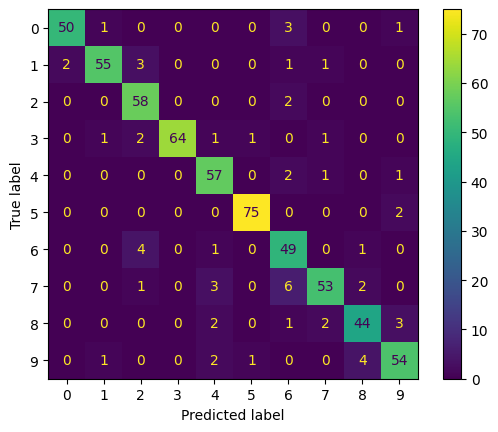

In [ ]:
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=mlphog.classes_)
disp1.plot()
plt.show()

In [ ]:
print(classification_report(ytest_1,predictions))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        55
           1       0.95      0.89      0.92        62
           2       0.85      0.97      0.91        60
           3       1.00      0.91      0.96        70
           4       0.86      0.93      0.90        61
           5       0.97      0.97      0.97        77
           6       0.77      0.89      0.82        55
           7       0.91      0.82      0.86        65
           8       0.86      0.85      0.85        52
           9       0.89      0.87      0.88        62

    accuracy                           0.90       619
   macro avg       0.90      0.90      0.90       619
weighted avg       0.91      0.90      0.90       619



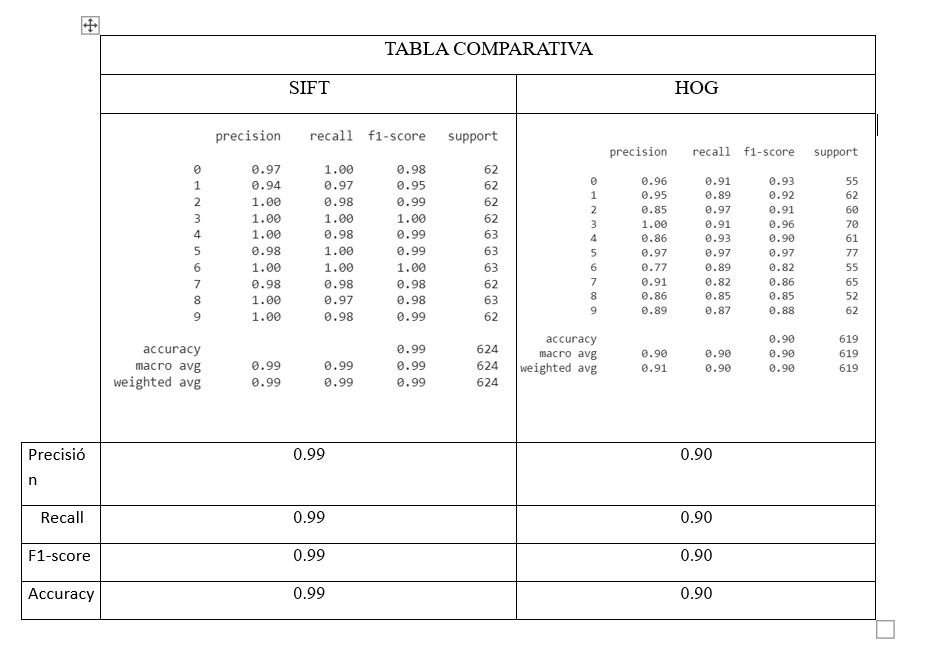


Para realizar el análisis correspondiente de las métricas entre Sift vs HOG, se observan la precisión, el recall, el f1-score y el accuracy, en donde se analiza cada uno de estos en los clasificadores.

El modelo basado en SIFT demuestra un rendimiento excepcional en la clasificación del dataset. Con valores de precisión, recall y F1-Score muy cercanos a 1.00 en la mayoría de las clases, es evidente que el modelo tiene una capacidad sobresaliente para clasificar de manera precisa y recuperar el modelo más relevante. Estos resultados sugieren que las características extraídas por SIFT son altamente capaces de capturar las sutilezas distintivas entre las clases. La alta precisión y recall generales son indicativos de una capacidad equilibrada para minimizar tanto los falsos positivos como los falsos negativos. La accuracy general del 0.98 confirma el alto rendimiento del modelo.

El modelo basado en HOG también logra un rendimiento bueno con respecto al dataset sin embargo es un poco inferior que el SIFT, lo que indica que también clasifica de manera precisa pero no tan exacta. A pesar de las diferencias, las métricas se mantienen en niveles significativos, lo que sugiere que las características extraídas por HOG tienen una buena puntuación según el criterio. La precisión y recall generales también son sólidos, lo que implica que el modelo de HOG logra encontrar un equilibrio entre minimizar los falsos positivos y los falsos negativos. La accuracy del 0.90 refleja un rendimiento global sólido, aunque no alcanza los niveles de SIFT en este dataset.

Ambos modelos, basados en SIFT y HOG, han demostrado ser capaces de realizar la clasificación del dataset con resultados notables. Aunque ambos enfoques logran un rendimiento bueno, existe una diferencia notable en términos de precisión y capacidad para capturar sutilezas distintivas entre las clases.



<font color='red'>Punto 4 (1.0). Pruebas adicionales de su mejor Clasificador</font>.

Tome un conjunto de 20 imagenes (use camaras monoculares convencionales), mostrando diferentes digitos del lenguaje de señas. Realice un programa que permita leer las imagenes, pre-procesarlas y dejarlas listas para servir de entrada a su mejor clasificador.  Muestre las imagenes procesadas y el valor de predicción de su red con porcentaje.

In [ ]:
#Pegue y ejecute aquí su código.

In [ ]:
!git clone https://github.com/JhonCaicedo0612/Lab1_CV_IMAGE.git

Cloning into 'Lab1_CV_IMAGE'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 91 (delta 3), reused 89 (delta 1), pack-reused 0
Receiving objects: 100% (91/91), 4.43 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
sld_dir = pathlib.Path('/content/Lab1_CV_IMAGE')
print(len(list(sld_dir.glob('*/*.jpg'))))

imagenes2={}

for ruta in sld_dir.glob('*'):
  categoria2=[]
  for filename in ruta.glob('*.jpg'):
    img2 = cv2.imread(str(filename))
    if img2 is not None:
        categoria2.append(img2)
  imagenes2[ruta.name] =  categoria2

20


In [ ]:
def prepro(imagenes):
  width = 64
  height = 64
  dim = (width, height)

  img_resize = {}

  for categoria, imgs in imagenes.items():
      nuevas_imagenes = []  # Lista para almacenar las nuevas imágenes copiadas
      for imagen in imgs:
        img_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(img_gris, dim, interpolation = cv2.INTER_AREA)
        nuevas_imagenes.append(resized)  # Copia la imagen a la nueva lista
      img_resize[categoria] = nuevas_imagenes

  return img_resize

In [ ]:
img_resize2 = {}
img_resize2 = prepro(imagenes2)

In [ ]:
feat_test2 = features(img_resize2)[1]
bovw_test2 = img_histos(feat_test2, diccionario_vis)
x_test2, y_test2 = preparar_datos(bovw_test2)
x_test2 = std.transform(x_test2)

In [ ]:
p2 = mlp.predict(x_test2)

In [ ]:
M2 = confusion_matrix(y_test2, p2)

In [ ]:
cm2 = confusion_matrix(y_test2, p2, labels= mlp.classes_)
print(cm2)

[[0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 1 0 2 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 1]]


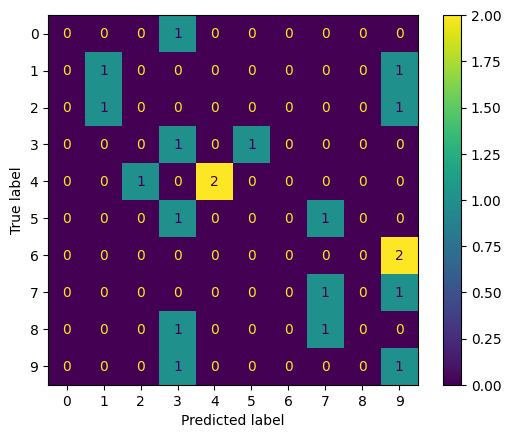

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=mlp.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test2,p2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         2
           3       0.20      0.50      0.29         2
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.33      0.50      0.40         2
           8       0.00      0.00      0.00         2
           9       0.17      0.50      0.25         2

    accuracy                           0.30        20
   macro avg       0.22      0.27      0.22        20
weighted avg       0.27      0.30      0.26        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
